In [2]:
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import math

In [9]:
class Figure:
    def __init__(self):
        super(Figure, self).__init__()
        self.points = []
    
    def draw(self, pivotPoints=[]):
        x = np.asarray([x for (x, _) in self.points])
        y = np.asarray([y for (_, y) in self.points])
        plt.scatter(x, y, [2 for i in x])
        for (px, py) in pivotPoints:
            plt.scatter(px, py, c = 'green')
        plt.show()

class Ellipse(Figure):
    def __init__(self, a, b, center, pointCount):
        super(Ellipse, self).__init__()
        for theta in np.linspace(0, 2*math.pi, num=pointCount, endpoint=False):
            cosTheta = math.cos(theta)
            sinTheta = math.sin(theta)
            self.points.append((center[0] + a*cosTheta, center[1] + b*sinTheta))
        
class Circle(Ellipse):
    def __init__(self, r, center, pointCount):
        super(Circle, self).__init__(r, r, center, pointCount)
        
class SuperEllipseHalfed(Figure):
    def __init__(self, aOne, bOne, nOne, aTwo, bTwo, nTwo, pointCount):
        super(SuperEllipseHalfed, self).__init__()
        for theta in np.linspace(0, 2*math.pi, num=pointCount, endpoint=False):
            cosTheta = math.cos(theta)
            sinTheta = math.sin(theta)
            if theta < math.pi:
                a = aOne
                b = bOne
                n = nOne
            else:
                a = aTwo
                b = bTwo
                n = nTwo
            x = a*pow(abs(cosTheta), 2/n)* np.sign(cosTheta)
            y = b*pow(abs(sinTheta), 2/n)* np.sign(sinTheta)   
            self.points.append((x, y))
    
class Oval(Figure):
#     def __init__(self, e1, e2, e3, center, pointCount):
#         super(Oval, self).__init__()
#         i = 0 
#         for theta in np.linspace(0, math.pi/2, num=pointCount/4, endpoint=False):
#             self.points.append(e1.points[i])
#             i += 1
#         for theta in np.linspace(math.pi/2, math.pi, num=pointCount/4, endpoint=False):
#             self.points.append(e2.points[i])
#             i += 1
#         for theta in np.linspace(math.pi, 2*math.pi, num=pointCount/2, endpoint=False):
#             self.points.append(e3.points[i])
#             i += 1
            
    def __init__(self, e1, e2, center, pointCount):
        super(Oval, self).__init__()
        i = 0 
        for theta in np.linspace(0, math.pi/2, num=pointCount/4, endpoint=False):
            self.points.append(e1.points[i])
            i += 1
        for theta in np.linspace(math.pi/2, 3*math.pi/2, num=pointCount/2, endpoint=False):
            self.points.append(e2.points[i])
            i += 1
        for theta in np.linspace(3*math.pi/2, 2*math.pi, num=pointCount/4, endpoint=False):
            self.points.append(e1.points[i])
            i += 1


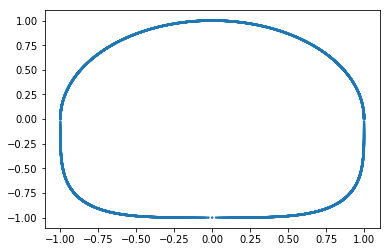

In [5]:
superEllipseHalfed = SuperEllipseHalfed(1, 1, 2, 1, 1, 4, 10000)
superEllipseHalfed.draw()

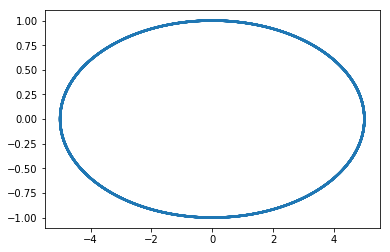

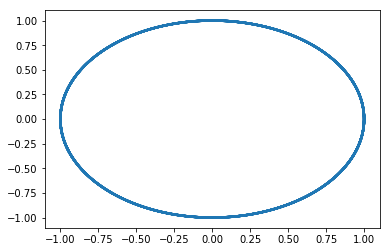

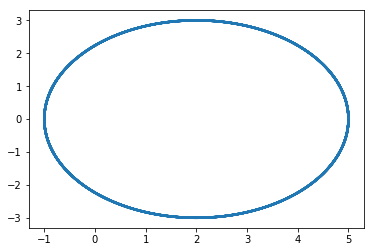

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:48: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


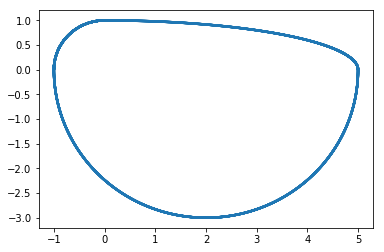

In [7]:
pointCount = 10000
e1 = Ellipse(5, 1, (0, 0), pointCount)
e2 = Circle(1, (0, 0), pointCount)
e3 = Circle(3, (2, 0), pointCount)
e1.draw()
e2.draw()
e3.draw()
center = (2, 0)

oval = Oval(e1, e2, e3, center, pointCount)
oval.draw()

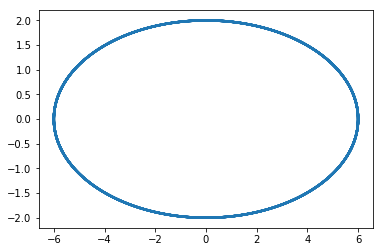

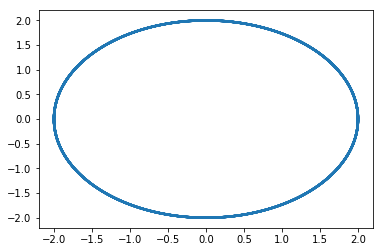

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:61: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:64: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:67: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


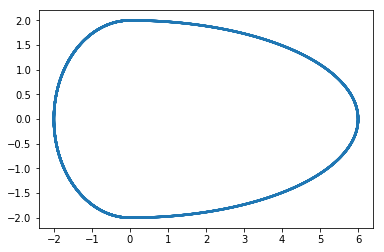

In [10]:
pointCount = 10000
e1 = Ellipse(6, 2, (0, 0), pointCount)
e2 = Circle(2, (0, 0), pointCount)
e1.draw()
e2.draw()
center = (0, 0)

oval4 = Oval(e1, e2, center, pointCount)
oval4.draw()

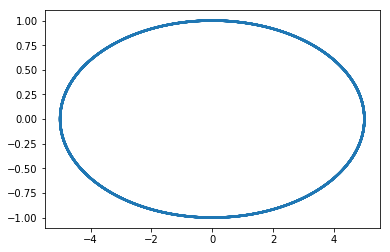

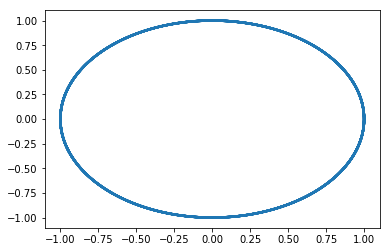

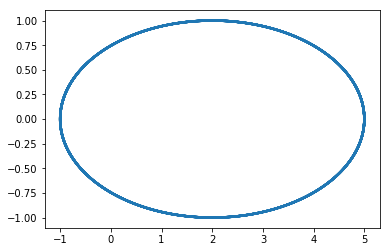

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:52: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:55: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:58: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


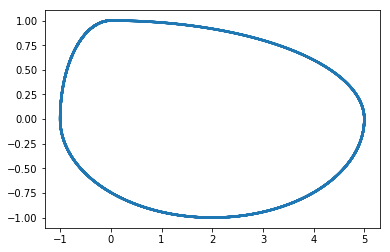

In [203]:
pointCount = 10000
e1 = Ellipse(5, 1, (0, 0), pointCount)
e2 = Circle(1, (0, 0), pointCount)
e3 = Ellipse(3, 1, (2, 0), pointCount)
e1.draw()
e2.draw()
e3.draw()
center = (2, 0)

oval2 = Oval(e1, e2, e3, center, pointCount)
oval2.draw()

In [12]:
class PivotPointsFinder:
    # Count is the number of coefs
    def __init__(self, points, startingCenterIndex, count):
        self.points = points
        self.startingCenterIndex = startingCenterIndex
        self.count = count
        
    def getEnsemble(self, centerIndex):
        radius = int((self.count - 1)/2)
        pointsCount = len(self.points)
        if centerIndex - radius < 0:
            return self.points[centerIndex - radius:] + self.points[:centerIndex + radius + 1]
        elif centerIndex + radius >= pointsCount:
            return self.points[centerIndex - radius:] + self.points[:centerIndex + radius + 1 - pointsCount]
        else:
            return self.points[centerIndex - radius:centerIndex + radius + 1]
        
    def getEnsembleCoefs(self, centerIndex):
        ensemble = self.getEnsemble(centerIndex)
        if self.count == 5:
            coefs = np.array([np.array([pow(x, 2), pow(y, 2), x*y, x, y]) for (x, y) in ensemble])
        elif self.count == 9:
            coefs = np.array([np.array([pow(x, 3), pow(y, 3), pow(x, 2)*y, x*pow(y, 2), pow(x, 2), pow(y, 2), x*y, x, y]) for (x, y) in ensemble])
        values = np.repeat(-1, self.count)
        return np.linalg.solve(coefs, values)
    
    def areEqual(p1, p2, threshold = 0.1):
        return abs(p1[0]-p2[0]) < threshold and abs(p1[1]-p2[1]) < threshold
    
    def addAsPivotPointIfSuitable(self, pivotPoints, initialCoefs, centerIndex, threshold):
        try:
            currentCoefs = self.getEnsembleCoefs(centerIndex)
        except:
            return initialCoefs
        for initialCoef, currentCoef in zip(initialCoefs, currentCoefs):
            if abs(initialCoef-currentCoef) > threshold:
                if len(pivotPoints) == 0 or not PivotPointsFinder.areEqual(self.points[pivotPoints[-1]], self.points[centerIndex]):
                    print(currentCoefs)
                    print("------")
                    pivotPoints.append(centerIndex)
                break
        
        return currentCoefs
    
    def findPivotPoints(self, step = 50, threshold = 0.01):
        pivotPoints = []
        initialCoefs = self.getEnsembleCoefs(self.startingCenterIndex)
        print("Initial coefs:")
        print(initialCoefs)
        print("------")
        # center -> right
        if self.startingCenterIndex < len(self.points) - 1:
            for centerIndex in np.arange(self.startingCenterIndex+1, len(self.points), step):
                initialCoefs = self.addAsPivotPointIfSuitable(pivotPoints, initialCoefs, centerIndex, threshold)
        
        for centerIndex in np.arange(0, self.startingCenterIndex, step):
            initialCoefs = self.addAsPivotPointIfSuitable(pivotPoints, initialCoefs, centerIndex, threshold)
        
#         # left <- center
#         if self.startingCenterIndex > 0:
#             for centerIndex in np.arange(self.startingCenterIndex-1, -1, -step):
#                 initialCoefs = self.addAsPivotPointIfSuitable(pivotPoints, initialCoefs, centerIndex, threshold)
            
#         for centerIndex in np.arange(len(self.points), self.startingCenterIndex, -step):
#             initialCoefs = self.addAsPivotPointIfSuitable(pivotPoints, initialCoefs, centerIndex, threshold)
        if len(pivotPoints) > 1 and PivotPointsFinder.areEqual(self.points[pivotPoints[-1]], self.points[pivotPoints[0]]):
            pivotPoints = pivotPoints[:-1]
        return pivotPoints        

In [119]:
pivotPointsFinder = PivotPointsFinder(superEllipseHalfed.points, 3700, 5)
pivotPointsIndices = pivotPointsFinder.findPivotPoints(step = 1)
pivotPoints = list(np.array(superEllipseHalfed.points)[pivotPointsIndices])
print(pivotPoints)

Initial coefs:
[-1.00000007e+00 -9.99999926e-01  9.38350206e-09 -1.08971057e-07
 -1.01902037e-07]
------
[ 9.99997785e-01 -2.25981230e-08 -1.88447861e-03  1.99999779e+00
 -1.88447898e-03]
------
[-1.00106213e+00 -1.00053106e+00 -1.18931459e-06  1.06212609e-03
  1.18931470e-06]
------
[array([-9.99999803e-01,  6.28318489e-04]), array([0.99999921, 0.00125664])]


In [13]:
pivotPointsFinder = PivotPointsFinder(oval4.points, 3700, 5)
pivotPointsIndices4 = pivotPointsFinder.findPivotPoints(step = 1)
pivotPoints = list(np.array(oval4.points)[pivotPointsIndices4])
print(pivotPoints)

Initial coefs:
[-2.50000019e-01 -2.49999981e-01  2.34587551e-09 -5.44855284e-08
 -5.09510186e-08]
------
[-1.48118494e-07  2.49999161e-01  4.71333763e-04  9.42667712e-04
  9.99998321e-01]
------
[ 4.93754872e-08  2.50000346e-01  1.57100656e-04 -3.14201374e-04
 -1.00000069e+00]
------
[array([-1.25663698e-03, -1.99999961e+00]), array([0.00376991, 1.99999961])]


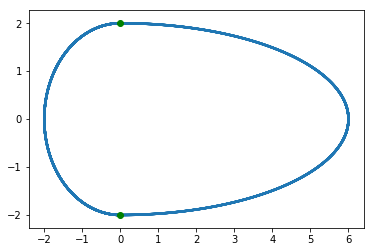

In [14]:
oval4.draw(pivotPoints)

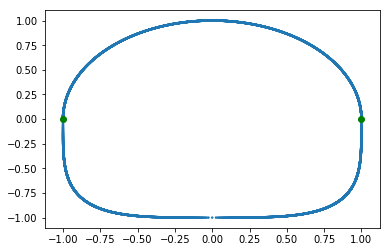

In [120]:
superEllipseHalfed.draw(pivotPoints)

Initial coefs:
[ 3.99998014e-02 -6.89908646e-07  5.27005651e-04 -3.99999007e-01
 -2.63502892e-03]
------
[-4.01187609e-02 -1.00148451e+00 -7.77033087e-07  5.93804658e-04
  3.88516671e-06]
------
[ 5.92005895e-08  1.00000079e+00  3.76951947e-04 -3.76952021e-04
 -2.00000079e+00]
------
[ 9.99994077e-01 -1.87557203e-06 -1.88501127e-03  1.99999408e+00
 -1.88501164e-03]
------
[ 4.00000285e-02  6.71001878e-08 -7.53633248e-05 -4.00000142e-01
  3.76816668e-04]
------
[array([4.99999605e+00, 1.25663673e-03]), array([0.00314159, 0.9999998 ]), array([-9.99999803e-01,  6.28318489e-04])]


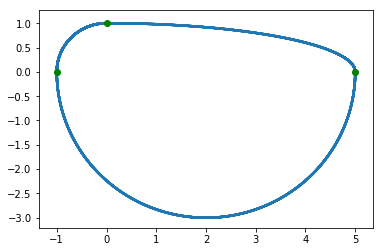

In [121]:
pivotPointsFinder = PivotPointsFinder(oval.points, 0, 5)
pivotPointsIndices = pivotPointsFinder.findPivotPoints(step = 1, threshold = 1)
pivotPoints = list(np.array(oval.points)[pivotPointsIndices])
print(pivotPoints)
oval.draw(pivotPoints)

Initial coefs:
[ 3.99991231e-02 -8.63480045e-06  6.40147972e-04 -3.99995616e-01
 -3.20074075e-03]
------
[-4.01187609e-02 -1.00148451e+00 -7.77033087e-07  5.93804658e-04
  3.88516671e-06]
------
[ 5.92005895e-08  1.00000079e+00  3.76951947e-04 -3.76952021e-04
 -2.00000079e+00]
------
[ 1.00000434e+00  3.25761020e-06 -1.88502074e-03  2.00000434e+00
 -1.88502111e-03]
------
[ 4.00002111e-02  1.97287916e-06 -2.25919737e-04 -4.00001055e-01
  1.12959882e-03]
------
[array([4.99999605e+00, 1.25663673e-03]), array([0.00314159, 0.9999998 ]), array([-9.99999803e-01,  6.28318489e-04])]


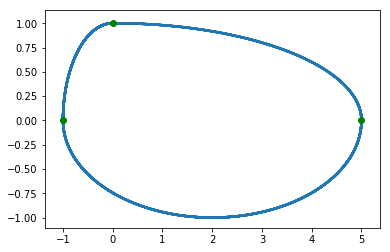

In [206]:
pivotPointsFinder = PivotPointsFinder(oval2.points, 0, 5)
pivotPointsIndices2 = pivotPointsFinder.findPivotPoints(step = 1, threshold = 1)
pivotPoints = list(np.array(oval2.points)[pivotPointsIndices2])
print(pivotPoints)
oval2.draw(pivotPoints)

In [16]:
class StandardCoordinateSystemTransformer:
    def transform(points, c):
#         z = c[6]*x+c[7]*y+1
        return list(map(lambda p: ((c[0]*p[0]+c[1]*p[1]+c[2])/(c[6]*p[0]+c[7]*p[1]+1),(c[3]*p[0]+c[4]*p[1]+c[5])/(c[6]*p[0]+c[7]*p[1]+1)), points))

In [27]:
import sys
# Proektivno-invariantnoe otobrazhenie figur 
def segmentLength(p1, p2):
    return pow(pow((p1[0] - p2[0]), 2) + pow((p1[1] - p2[1]), 2), 1/2)

def getPolarForPolus(points, righterPivotPointIndex, randomPolarPoint, randomIndexDiff = 500):
    randomOvalPoint1Index = (righterPivotPointIndex-randomIndexDiff) % len(points)
    randomOvalPoint2Index = (righterPivotPointIndex+randomIndexDiff+451) % len(points)
    randomOvalPoint1 = points[randomOvalPoint1Index]
    randomOvalPoint2 = points[randomOvalPoint2Index]

    k1, b1 = getLineByPoints(randomOvalPoint1, randomPolarPoint)
    k2, b2 = getLineByPoints(randomOvalPoint2, randomPolarPoint)
    randomOvalLine1IntersectionPoint = getPk(points, k1, b1, randomOvalPoint1Index, randomOvalPoint2Index)
    randomOvalLine2IntersectionPoint = getPk(points, k2, b2, randomOvalPoint1Index, randomOvalPoint2Index)
    
    crossline1 = getLineByPoints(randomOvalLine1IntersectionPoint, randomOvalPoint2)
    crossline2 = getLineByPoints(randomOvalLine2IntersectionPoint, randomOvalPoint1)

    polarPoint1 = intersectionPoint(crossline1[0], crossline1[1], crossline2[0], crossline2[1])

    randomOvalLine12 = getLineByPoints(randomOvalPoint1, randomOvalPoint2)
    intersectionPointsLine = getLineByPoints(randomOvalLine1IntersectionPoint, randomOvalLine2IntersectionPoint)

    polarPoint2 = intersectionPoint(randomOvalLine12[0], randomOvalLine12[1], intersectionPointsLine[0], intersectionPointsLine[1])
    
#     print(polarPoint1)
#     print(polarPoint2)
#     oval.draw([randomOvalLine1IntersectionPoint, randomOvalPoint2, randomOvalLine2IntersectionPoint, randomOvalPoint1, polarPoint1, polarPoint2])
    return getLineByPoints(polarPoint1, polarPoint2)

# Calculates P when derivatives to pivotPoints are parallel
def getPOnParallel(points, pivotPoint1Index, pivotPoint2Index):
    pivotPoint1 = points[pivotPoint1Index]
    pivotPoint2 = points[pivotPoint2Index]
    polar = getLineByPoints(pivotPoint1, pivotPoint2)
    righterPivotPointIndex = pivotPoint1Index if pivotPoint1[0] > pivotPoint2[0] else pivotPoint2Index
    righterPivotPointX = points[righterPivotPointIndex][0]
    # Taking random polus point and finding polar
    randomPolarPoint1 = (righterPivotPointX + 5, polar[0]*(righterPivotPointX + 5) + polar[1]) 
    randomPolarPoint2 = (righterPivotPointX + 10, polar[0]*(righterPivotPointX + 10) + polar[1])
    k1, b1 = getPolarForPolus(points, righterPivotPointIndex, randomPolarPoint1, randomIndexDiff = 500)
    k2, b2 = getPolarForPolus(points, righterPivotPointIndex, randomPolarPoint2)
#     x1, y1 = [4, k1*4+b1], [-4, k1*-4+b1]
#     x2, y2 = [4, k2*4+b2], [-4, k2*-4+b2]
#     plt.plot(x1, y1, x2, y2, marker = 'o')
#     plt.show()
    return intersectionPoint(k1, b1, k2, b2)        

def wurf(p1, p2, p3, p4):
#     sortedList = sorted([p1, p2, p3, p4], key=lambda p: segmentLength(p1, p))
#     p2 = sortedList[1]
#     p3 = sortedList[2]
#     p4 = sortedList[3]
    
        
    a = segmentLength(p1, p2)
    b = segmentLength(p3, p2)
    c = segmentLength(p4, p3)
    
    return a*c/(b*(a+b+c))

# Point of intersection between two lines represented in the form of kx + b
def intersectionPoint(k1, b1, k2, b2):
    x = -(b1 - b2) / (k1 - k2)
    return (x, k1 * x + b1) if abs(k1-k2) > 0.01 else None

def getP(points, pivotPoint1Index, pivotPoint2Index):
    k1, b1 = tangent(points[pivotPoint1Index-2], points[pivotPoint1Index-1], points[pivotPoint1Index], points[(pivotPoint1Index+1)%len(points)], points[(pivotPoint1Index+1)%len(points)])
    k2, b2 = tangent(points[pivotPoint2Index-2], points[pivotPoint2Index-1], points[pivotPoint2Index], points[(pivotPoint2Index+1)%len(points)], points[(pivotPoint2Index+1)%len(points)])
    P = intersectionPoint(k1, b1, k2, b2)
    # tangents do not intersect
    if P == None :
        return getPOnParallel(points, pivotPoint1Index, pivotPoint2Index)
    else:
        return P

def getPj(points, pivotPoint1Index, pivotPoint2Index, P, Pi):
    k1, b1 = getLineByPoints(points[pivotPoint1Index], points[pivotPoint2Index])
    k2, b2 = getLineByPoints(P, Pi)
    return intersectionPoint(k1, b1, k2, b2)

# Find closest point to the line [P, P_i] among points forming the oval (find P_k)
def getPk(points, k, b, pivotPoint1Index, pivotPoint2Index):
    minDelta = sys.maxsize
    kOpt = 0
    numPoints = len(points)

    k1 = pivotPoint2Index+100
    while k1 != pivotPoint1Index-100:
        delta = getLinePointDistance((k, b), points[k1])
        if delta <= minDelta:
            minDelta = delta
            kOpt = k1
        k1 = (k1 + 1) % numPoints

    if minDelta > 10:
        return None
    else:
        return points[kOpt]

def getTi(points, i, pivotPoint1Index, pivotPoint2Index):
    k1, b1 = tangent(points[i-2], points[i-1], points[i], points[i+1], points[i+2])
    k2, b2 = getLineByPoints(points[pivotPoint1Index], points[pivotPoint2Index])
    return intersectionPoint(k1, b1, k2, b2)

def buildWf1Wf2(points, pivotPoint1Index, pivotPoint2Index):
    P = getP(points, pivotPoint1Index, pivotPoint2Index)
    if P == None:
        print("Sorry, different approach needed for such a case")
        return
    A = points[pivotPoint1Index]
    B = points[pivotPoint2Index]
    wf1s = []
    wf2s = []
    for i in range(pivotPoint1Index+1,pivotPoint2Index):
        Pi = points[i]
        Pj = getPj(points, pivotPoint1Index, pivotPoint2Index, P, Pi)
        k, b = getLineByPoints(P, Pi)
        Pk = getPk(points, k, b, pivotPoint1Index, pivotPoint2Index)
        wf1s.append(wurf(P, Pi, Pj, Pk))
        Ti = getTi(points, i, pivotPoint1Index, pivotPoint2Index)
        wf2s.append(wurf(Ti, A, Pj, B))
    plotWf1Wf2(wf1s, wf2s)
    

def buildWf1(points, pivotPoint1Index, pivotPoint2Index, fromIndex, toIndex, oval):
    P = getP(points, pivotPoint1Index, pivotPoint2Index)
    if P == None:
        print("Sorry, different approach needed for such a case")
        return
    A = points[pivotPoint1Index]
    B = points[pivotPoint2Index]
    wf1s = []
    i = fromIndex
    while i != toIndex:
        Pk = points[i]
        k, b = getLineByPoints(P, Pk)
        Pi = getPk(points, k, b, pivotPoint2Index, pivotPoint1Index)
        Pj = getPj(points, pivotPoint1Index, pivotPoint2Index, P, Pk)
        if P == None or Pi == None or Pj == None or Pk == None or P[1] == None or Pi[1] == None or Pj[1] == None or Pk[1] == None or P[0] == None or Pi[0] == None or Pj[0] == None or Pk[0] == None:
            i = (i+1)%len(points)
            wf1s.append(1)
            continue
        wf1s.append(wurf(P, Pi, Pj, Pk))
        if i == fromIndex + 1000:
            oval.draw([A, B, P, Pi, Pj, Pk])
            print(P)
            print(Pi)
            print(Pj)
            print(Pk)
            print(wf1s[-1])
        i = (i+1)%len(points)
    return wf1s

def plotWf11Wf12Wf13(points, pivotPointsIndexes, oval):
    wf11 = buildWf1(points, pivotPointsIndexes[0], pivotPointsIndexes[1], (pivotPointsIndexes[2] + 50)%len(points), len(points) - 50, oval)
#     print(wf11)
    wf12 = buildWf1(points, pivotPointsIndexes[0], pivotPointsIndexes[2], (pivotPointsIndexes[2] + 50)%len(points), len(points) - 50, oval)
    wf13 = buildWf1(points, pivotPointsIndexes[1], pivotPointsIndexes[2], (pivotPointsIndexes[2] + 50)%len(points), len(points) - 50, oval)
    plt.subplot(2, 1, 1)
    plt.plot(wf11, 'r')
    plt.plot(wf12, 'g')
    plt.plot(wf13, 'b')
#     plt.axis([0, 100, 0, 2])
    plt.subplot(2, 1, 2)
    plt.plot(wf11, wf12, 'g')
    plt.plot(wf11, wf13, 'b')
    plt.show()

def plotWf1Wf2(wf1s, wf2s):
    plt.plot(wf1s, wf2s, 'ro')
    plt.show()

# Returns k, b of a line which p1, p2 lie on
def getLineByPoints(p1, p2):
    x1, y1 = p1
    x2, y2 = p2
    k = (y2-y1)/(x2-x1)
    b = y2 - k*x2
    return (k, b)

# Distance between line represented by two points and p
def getLinePointDistance(l, p):
    k, b = l
    x, y = p
    return abs(k * p[0] - p[1] + b) / (k ** 2 + 1) ** 0.5

# df = (y2-y1)/(x2-x1)
def derivative(a1, a2, c1, c2):
    a1x, a1y = a1
    a2x, a2y = a2
    c1x, c1y = c1
    c2x, c2y = c2
    return (
        (a1y + a2y - c1y - c2y) /
        (a1x + a2x - c1x - c2x)
    )

# y = f ’(x0) · (x − x0) + f (x0)
# Returns (k, b)
def tangent(a1, a2, current, c1, c2):
    if a1[0] + a2[0] - c1[0] - c2[0] == 0:
        return None
    k = derivative(a1, a2, c1, c2)
    return (k, current[1] - k * current[0])

# plotWf11Wf12Wf13(oval.points, pivotPointsIndices)



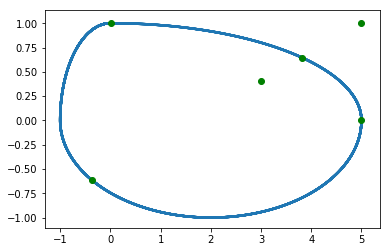

(4.994666409946482, 0.9991843728722642)
(3.8183041377085605, 0.6456176426324699)
(3.0017100853115144, 0.40066279693575824)
(-0.37161987171828104, -0.6124104636662284)
0.905712146378404


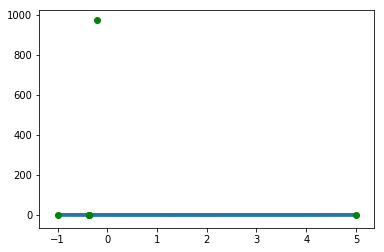

(-0.2040816578503108, 974.4181651285253)
(-0.37162710322264547, 0.9283820852161815)
(-0.37151452276649827, 0.0006941333291343492)
(-0.37161987171828104, -0.6124104636662284)
0.6598509137057624


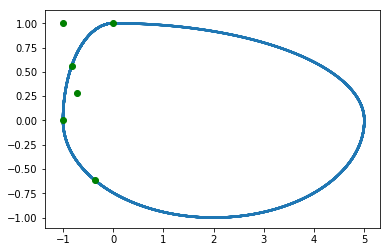

(-0.9991833679756703, 1.0001635452732147)
(-0.8281386065214702, 0.5605233700646901)
(-0.7191014801094837, 0.2804709955292711)
(-0.37161987171828104, -0.6124104636662284)
0.8691401347710942


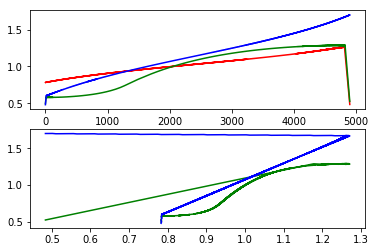

In [209]:
plotWf11Wf12Wf13(oval2.points, pivotPointsIndices2)

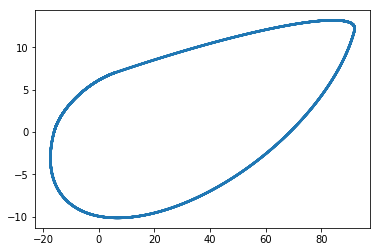

In [231]:
newPoints = StandardCoordinateSystemTransformer.transform(oval.points, [18, 4, 2, 2, 5, 2, 0, 0, 1])
oval3 = Figure()
oval3.points = newPoints
oval3.draw()

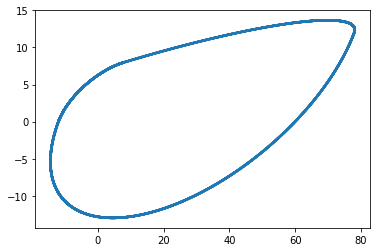

In [20]:
newPoints = StandardCoordinateSystemTransformer.transform(oval.points, [15, 5, 3, 2, 6, 2, 0, 0, 1])
oval5 = Figure()
oval5.points = newPoints
oval5.draw()

Initial coefs:
[ 0.00021514  0.0001441  -0.00035223 -0.02933564  0.02401541]
------
[ 0.00036939  0.02079931 -0.00554369  0.03843923 -0.28843931]
------
[ 0.0069444   0.00484665 -0.01160306  0.16666612 -0.13923713]
------
[ 0.00021642  0.00015105 -0.00036161 -0.02942261  0.02458027]
------
[array([8.0471229, 8.006282 ]), array([-1.19968554e+01,  3.77030572e-03]), array([77.99056634, 11.98868908])]


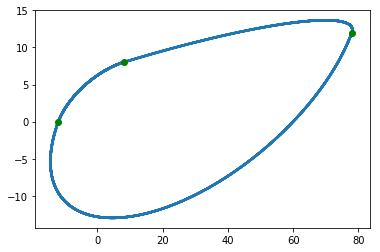

In [23]:
pivotPointsFinder = PivotPointsFinder(oval5.points, 0, 5)
pivotPointsIndices5 = pivotPointsFinder.findPivotPoints(step = 1, threshold = 0.1)
pivotPoints = list(np.array(oval5.points)[pivotPointsIndices5])
print(pivotPoints)
oval5.draw(pivotPoints)

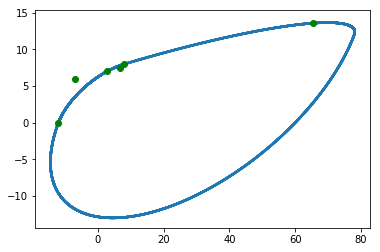

(-6.986932793270244, 6.002614535687688)
(2.921337377865582, 7.040702610354047)
(6.590714571511456, 7.424814365839369)
(65.35254911128817, 13.579862354391642)
2.1934586952477253


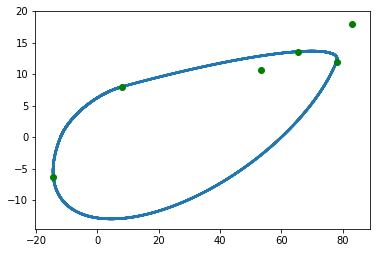

(83.00817326106805, 17.996734397896773)
(-14.33308868086532, -6.350325305474055)
(53.39402667152024, 10.588222806689881)
(65.35254911128817, 13.579862354391642)
0.09709124988410392


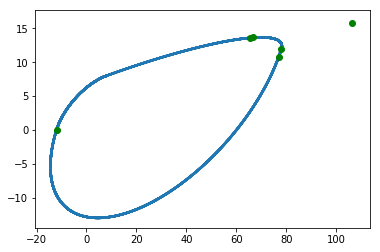

(66.66516369430528, 13.650027364201605)
(76.94694719456322, 10.834878927321837)
(106.42065611440421, 15.775132899174794)
(65.35254911128817, 13.579862354391642)
0.17962487072923816


ValueError: x and y must have same first dimension, but have shapes (9901,) and (9355,)

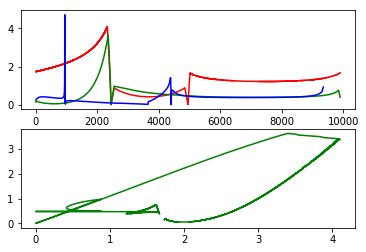

In [28]:
plotWf11Wf12Wf13(oval5.points, pivotPointsIndices5, oval5)

Initial coefs:
[ 1.46351309e-04  8.85333262e-05 -2.27781908e-04 -2.41953180e-02
  1.88311836e-02]
------
[-0.00087006 -0.05655707  0.01282074 -0.02232965  0.20071854]
------
[ 3.07495799e-04  2.49285134e-02 -5.53729616e-03  3.50711136e-02
 -3.15775321e-01]
------
[ 0.00390623  0.0025192  -0.00627407  0.12499962 -0.1003855 ]
------
[array([92.00495549, 12.00627529]), array([6.05654787, 7.0062822 ]), array([-1.59974832e+01,  3.14198723e-03])]


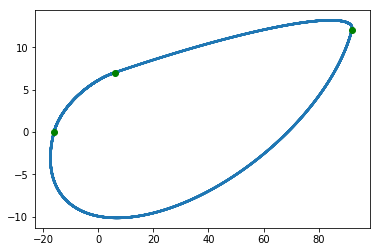

In [235]:
pivotPointsFinder = PivotPointsFinder(oval3.points, 0, 5)
pivotPointsIndices3 = pivotPointsFinder.findPivotPoints(step = 1, threshold = 0.1)
pivotPoints = list(np.array(oval3.points)[pivotPointsIndices3])
print(pivotPoints)
oval3.draw(pivotPoints)


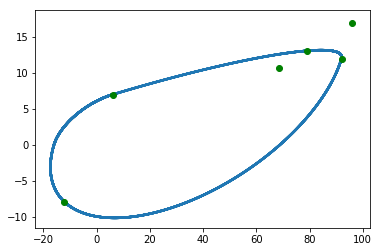

(95.90073287052522, 16.985254684253945)
(79.0398787143261, 13.092107434785666)
(68.3744636618942, 10.631586691435794)
(-12.0380832549238, -7.92939669842999)
1.1777870934839367


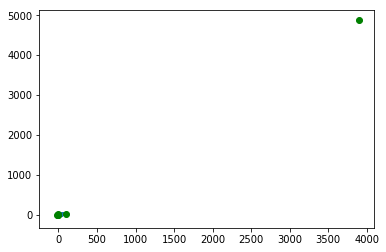

(3895.9991906335035, 4873.68266227701)
(-0.9643251757028457, 5.900989590230985)
(-4.6807036518477085, 1.260861857395024)
(-12.0380832549238, -7.92939669842999)
1.9746472987531565


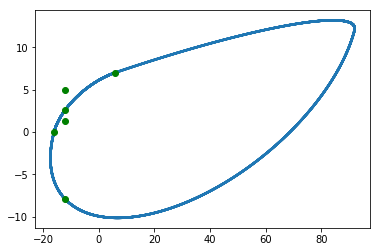

(-11.984646442468279, 5.002450990414896)
(-11.990882608722153, 2.592300395125335)
(-12.000059286288957, 1.2725026723547117)
(-12.0380832549238, -7.92939669842999)
1.2994045612471603


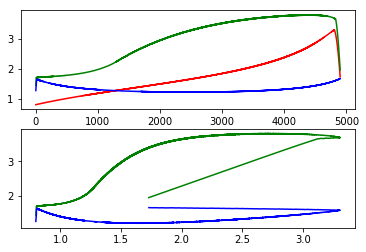

In [239]:
plotWf11Wf12Wf13(oval3.points, pivotPointsIndices3, oval3)

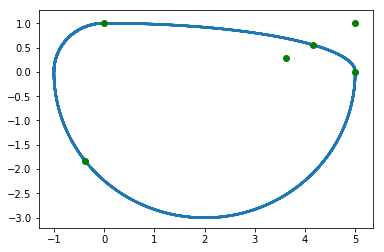

(4.994666409946482, 0.9991843728722642)
(4.156475168688876, 0.5558314194815828)
(3.6261703846795523, 0.2758491844153268)
(-0.37161987171828104, -1.8372313909986853)
1.1779821569353033


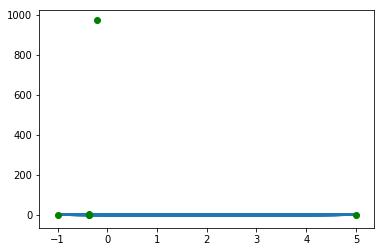

(-0.2040816578502031, 974.418165128505)
(-0.37104371023705085, 0.9286154021410173)
(-0.37130445961981623, 0.0006941553269006953)
(-0.37161987171828104, -1.8372313909986853)
1.975079724868107


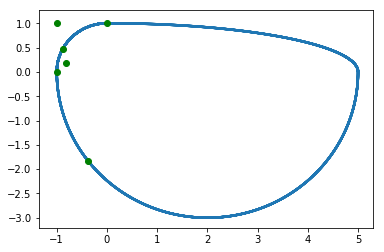

(-0.9991833679756702, 1.0001635452732147)
(-0.88199530029405, 0.4712581991426871)
(-0.8181744770837328, 0.18177032530439374)
(-0.37161987171828104, -1.8372313909986853)
1.300366233605453


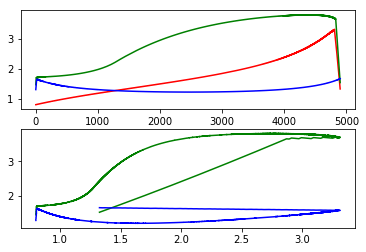

In [240]:
plotWf11Wf12Wf13(oval.points, pivotPointsIndices, oval)

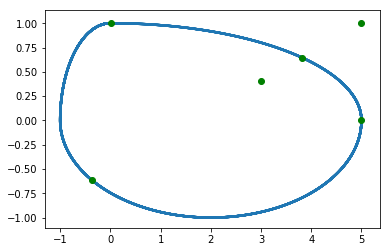

(4.994666409946482, 0.9991843728722642)
(3.8183041377085605, 0.6456176426324699)
(3.0017100853115144, 0.40066279693575824)
(-0.37161987171828104, -0.6124104636662284)
0.905712146378404


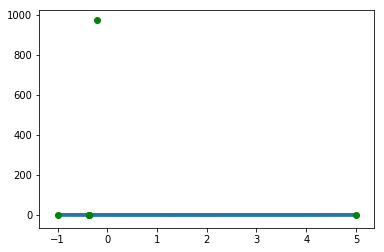

(-0.2040816578503108, 974.4181651285253)
(-0.37162710322264547, 0.9283820852161815)
(-0.37151452276649827, 0.0006941333291343492)
(-0.37161987171828104, -0.6124104636662284)
0.6598509137057624


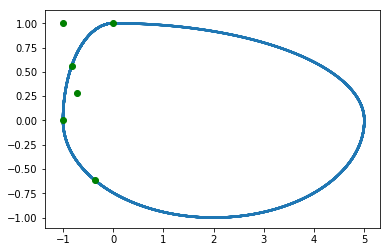

(-0.9991833679756703, 1.0001635452732147)
(-0.8281386065214702, 0.5605233700646901)
(-0.7191014801094837, 0.2804709955292711)
(-0.37161987171828104, -0.6124104636662284)
0.8691401347710942


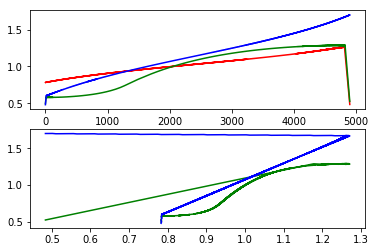

In [241]:
plotWf11Wf12Wf13(oval2.points, pivotPointsIndices2, oval2)